In [ ]:
!pip install simpy

In [ ]:
import numpy as np
import simpy as sp
import statistics as st
import matplotlib.pyplot as plt
import prettytable as pt

Многоканальная СМО с ограниченной очередью и ограниченным временем ожидания в очереди

$ n $ - число каналов в СМО \
$ m $ - число мест в очереди \
$ \lambda $ - интенсивность поступления в СМО заявок \
$ \mu $ - интенсивность обслуживания заявок \

Финальные вероятности

$ \rho = \lambda / \mu $

$ \beta = v / \mu $

$ p_{0} = (1 + \frac{\rho}{1!} + \frac{\rho^2}{2!} + ...+ \frac{\rho^n}{n!} + \frac{\rho^n}{n!} * \sum_{i = 1}^m \frac{\rho^i}{\prod_{l = 1}^i (n + l\beta)})^{-1} $

$ p_{k} = \frac{\rho^k}{k!} * p_{0}, (k = \bar{1, n}) $ 

$ p_{n + i} = p_{n} * \frac{\rho^i}{\prod_{l = 1}^i (n + l\beta)}, (i = \bar{1, m}) $ 

In [ ]:
def get_theoretical_final_probabilities(n, m, _lambda, mu, v):
  rho = _lambda / mu
  beta = v / mu
  p_0 = (np.sum([(rho ** i) / np.math.factorial(i) for i in range(n + 1)]) + ((rho ** n) / np.math.factorial(n)) * (np.sum([(rho ** i) / (np.prod([n + l * beta for l in range(1, i + 1)])) for i in range(1, m + 1)]))) ** -1
  final_probabilities = [p_0] + [((rho ** k) / np.math.factorial(k)) * p_0 for k in range(1, n + 1)]
  p_n = final_probabilities[-1]
  final_probabilities += [((rho ** i) / (np.prod([n + l * beta for l in range(1, i + 1)]))) * p_n for i in range(1, m + 1)]
  return final_probabilities

Вероятность образования очереди

$ p_{q} = \sum_{i = 0}^{m - 1} p_{n + i} $

In [ ]:
def get_theoretical_queue_probability(n, m, final_probabilities):
  return np.sum([final_probabilities[n + i] for i in range(0, m)])

Вероятность отказа

$ p_{r} = p_{n + m} $

In [ ]:
def get_theoretical_reject_probability(n, m, final_probabilities):
  return final_probabilities[n + m]

Относитальная пропускная способность

$ Q = 1 - p_{q} $

In [ ]:
def get_theoretical_relative_bandwidth(reject_probability):
  return 1 - reject_probability

Абсолютная пропускная способность

$ A = Q \lambda $

In [ ]:
def get_theoretical_absolute_bandwidth(relative_bandwidth, _lambda):
  return relative_bandwidth * _lambda

Среднее число элементов в очереди

$ L_{q} = \sum_{i = 1}^{m} i * p_{n + i} $

In [ ]:
def get_theoretical_average_queue_items_count(n, m, final_probabilities):
  return np.sum([i * final_probabilities[n + i] for i in range(1, m + 1)])

Среднее число элементов в СМО

$ L_{qs} = \sum_{k = 1}^{n} k * p_{k} + \sum_{i = 1}^{m} (n + i) * p_{n + i} $

In [ ]:
def get_theoretical_average_queue_system_items_count(n, m, final_probabilities):
  return np.sum([k * final_probabilities[k] for k in range(1, n + 1)]) + np.sum([(n + i) * final_probabilities[n + i] for i in range(1, m + 1)])

Среднее число активных каналов

$ k = Q * \rho $

In [ ]:
def get_theoretical_average_active_channal_count(relative_bandwidth, rho):
  return relative_bandwidth * rho

Среднее время пребывания элемента в очереди

$ T_{q} = L_{q} / \lambda $

In [ ]:
def get_theoretical_average_queue_items_time(reject_probability, _lambda):
  return reject_probability / _lambda

Среднее время пребывания элемента в СМО

$ T_{qs} = L_{qs} / \lambda $

In [ ]:
def get_theoretical_average_queue_system_items_time(average_queue_system_items_count, _lambda):
  return average_queue_system_items_count / _lambda

In [ ]:
def get_theoretical_info(n, m, _lambda, mu, v):
  final_probabilities = get_theoretical_final_probabilities(n, m, _lambda, mu, v)
  queue_probability = get_theoretical_queue_probability(n, m, final_probabilities)
  reject_probability = get_theoretical_reject_probability(n, m, final_probabilities)
  relative_bandwidth = get_theoretical_relative_bandwidth(reject_probability)
  absolute_bandwidth = get_theoretical_absolute_bandwidth(relative_bandwidth, _lambda)
  average_queue_items_count = get_theoretical_average_queue_items_count(n, m, final_probabilities)
  average_queue_system_items_count = get_theoretical_average_queue_system_items_count(n, m, final_probabilities)
  average_active_channal_count = get_theoretical_average_active_channal_count(relative_bandwidth, _lambda / mu)  
  average_queue_items_time = get_theoretical_average_queue_items_time(average_queue_items_count, _lambda)
  average_queue_system_items_time = get_theoretical_average_queue_system_items_time(average_queue_system_items_count, _lambda)
  return final_probabilities, queue_probability, reject_probability, relative_bandwidth, absolute_bandwidth, average_queue_items_count, average_queue_system_items_count, average_active_channal_count, average_queue_items_time, average_queue_system_items_time

In [ ]:
class QueueSystem(object):
  def __init__(self, env, n, m, _lambda, mu, v): 
    self.n = n
    self.m = m
    self._lambda = _lambda
    self.mu = mu
    self.v = v

    self.counts = []
    self.times = []
    self.queue_counts = []
    self.queue_times = []
    
    self.serve_items = []
    self.reject_items = []
    
    self.env = env
    self.resources = sp.Resource(env, n)

  def serve(self):
    yield self.env.timeout(np.random.exponential(1.0 / self.mu))

  def wait(self):
    yield self.env.timeout(np.random.exponential(1.0 / self.v))

  def get_workload(self):
    return self.resources.count
  
  def get_queue_len(self):
    return len(self.resources.queue)

  def start(self, action):
    while True:
      yield self.env.timeout(np.random.exponential(1 / self._lambda))
      self.env.process(action(self))

Финальные вероятности

In [ ]:
def get_experimental_final_probabilities(queue_system: QueueSystem):
  items = np.array(queue_system.reject_items + queue_system.serve_items)
  return [(len(items[items == i]) / len(items)) for i in range(1, queue_system.n + queue_system.m + 2)]

Вероятность образования очереди

In [ ]:
def get_experimental_queue_probability(queue_system: QueueSystem):
  items = np.array(queue_system.reject_items + queue_system.serve_items)
  return np.sum([(len(items[items == i]) / len(items)) for i in range(1, queue_system.n + queue_system.m + 2) if i > queue_system.n and i < queue_system.n + queue_system.m + 1])

Вероятность отказа

In [ ]:
def get_experimental_reject_probability(queue_system: QueueSystem):
  items = np.array(queue_system.reject_items + queue_system.serve_items)
  return (len(items[items == queue_system.n + queue_system.m + 1]) / len(items))

Относитальная пропускная способность

In [ ]:
def get_experimental_relative_bandwidth(queue_system: QueueSystem):
  return 1 - get_experimental_reject_probability(queue_system)

Абсолютная пропускная способность

In [ ]:
def get_experimental_absolute_bandwidth(queue_system: QueueSystem):
  return get_experimental_relative_bandwidth(queue_system) * queue_system._lambda

Среднее число элементов в очереди

In [ ]:
def get_experimental_average_queue_items_count(queue_system: QueueSystem):
  return st.mean(queue_system.queue_counts)

Среднее число элементов в СМО

In [ ]:
def get_experimental_average_queue_system_items_count(queue_system: QueueSystem):
  return st.mean(queue_system.counts)

Среднее число активных каналов

In [ ]:
def get_experimental_average_active_channal_count(queue_system: QueueSystem):
  return get_experimental_relative_bandwidth(queue_system) * queue_system._lambda / queue_system.mu

Среднее время пребывания элемента в очереди

In [ ]:
def get_experimental_average_queue_items_time(queue_system: QueueSystem):
  return st.mean(queue_system.queue_times)

Среднее время пребывания элемента в СМО

In [ ]:
def get_experimental_average_queue_system_items_time(queue_system: QueueSystem):
  return st.mean(queue_system.times)

In [ ]:
def get_experimental_info(queue_system: QueueSystem):
  final_probabilities = get_experimental_final_probabilities(queue_system)
  queue_probability = get_experimental_queue_probability(queue_system)
  reject_probability = get_experimental_reject_probability(queue_system)
  relative_bandwidth = get_experimental_relative_bandwidth(queue_system)
  absolute_bandwidth = get_experimental_absolute_bandwidth(queue_system)
  average_queue_items_count = get_experimental_average_queue_items_count(queue_system) 
  average_queue_system_items_count = get_experimental_average_queue_system_items_count(queue_system) 
  average_active_channal_count = get_experimental_average_active_channal_count(queue_system) 
  average_queue_items_time = get_experimental_average_queue_items_time(queue_system) 
  average_queue_system_items_time = get_experimental_average_queue_system_items_time(queue_system)
  return final_probabilities, queue_probability, reject_probability, relative_bandwidth, absolute_bandwidth, average_queue_items_count, average_queue_system_items_count, average_active_channal_count, average_queue_items_time, average_queue_system_items_time

In [ ]:
def serve(queue_system: QueueSystem):
  queue_len = queue_system.get_queue_len()
  qn_count = queue_system.get_workload()
  with queue_system.resources.request() as request:
    queue_current_len = queue_system.get_queue_len()
    qn_current_count = queue_system.get_workload()
    queue_system.queue_counts.append(queue_len)
    queue_system.counts.append(queue_len + qn_count)
    if queue_current_len <= queue_system.m:
      start = queue_system.env.now
      response = yield request | queue_system.env.process(queue_system.wait())
      queue_system.queue_times.append(queue_system.env.now - start)
      if request in response:
        yield queue_system.env.process(queue_system.serve())
        queue_system.serve_items.append(queue_current_len + qn_current_count)
      else:
        queue_system.reject_items.append(queue_current_len + qn_current_count)
      queue_system.times.append(queue_system.env.now - start)
    else:
      queue_system.reject_items.append(queue_system.n + queue_system.m + 1)
      queue_system.times.append(0)
      queue_system.queue_times.append(0)

In [ ]:
def test_case(n, m, _lambda, mu, v, time, _round):
  env = sp.Environment()
  queue_system = QueueSystem(env, n, m, _lambda, mu, v)
  env.process(queue_system.start(serve))
  env.run(until = time)
  
  theoretical_info = (get_theoretical_info(n, m, _lambda, mu, v))
  experimental_info = (get_experimental_info(queue_system))
  
  final_probabilities_info = pt.PrettyTable()
  final_probabilities_info.add_column("Теоретические финальные вероятности", np.around(theoretical_info[0], _round))
  final_probabilities_info.add_column("Эмпирические финальные вероятности", np.around(experimental_info[0], _round))
  print(final_probabilities_info)
  
  plot_histograms(np.around(theoretical_info[0], _round), np.around(experimental_info[0], _round))

  field_names = ["Вероятность образования очереди", 
                 "Вероятность отказа", 
                 "Относитальная пропускная способность", 
                 "Абсолютная пропускная способность", 
                 "Среднее число элементов в очереди",
                 "Среднее число элементов в СМО",
                 "Среднее число активных каналов",
                 "Среднее время пребывания элемента в очереди",
                 "Среднее время пребывания элемента в СМО"]
  
  for index, value in enumerate(field_names):
    info = pt.PrettyTable()
    info.field_names = ["Исследование", value]
    info.add_row(["Теоретическое", np.around(theoretical_info[index + 1], _round)])
    info.add_row(["Эмпирическое", np.around(experimental_info[index + 1], _round)])
    print(info)


In [ ]:
def plot_histograms(theoretical_probabilities, experimental_probabilities):
    plt.style.use('default')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
    
    ax1.set_title('Теоретические финальные вероятности')
    ax1.bar(range(len(theoretical_probabilities)), theoretical_probabilities, width = 0.2)
    
    ax2.set_title('Эмпирические финальные вероятности')
    ax2.bar(range(len(experimental_probabilities)), experimental_probabilities, width = 0.2)

    ax3.set_title('Финальные вероятности')
    ax3.bar(range(len(theoretical_probabilities)), theoretical_probabilities - experimental_probabilities, width = 0.3)
    ax3.axhline(y = 0, xmin = 0, xmax = len(theoretical_probabilities), color='red')
    
    plt.show()

Тест 1
+-------------------------------------+------------------------------------+
| Теоретические финальные вероятности | Эмпирические финальные вероятности |
+-------------------------------------+------------------------------------+
|             0.0859098659            |            0.0884574255            |
|             0.1718197318            |            0.172553803             |
|             0.1718197318            |            0.1714677182            |
|             0.1561997562            |            0.1539901083            |
|             0.1301664635            |            0.1282081273            |
|             0.1001280488            |            0.0980650982            |
|             0.0715200349            |            0.0725003342            |
|             0.0476800233            |            0.047520385             |
|             0.0298000145            |            0.0308782248            |
|             0.0175294203            |            0.0183464777      

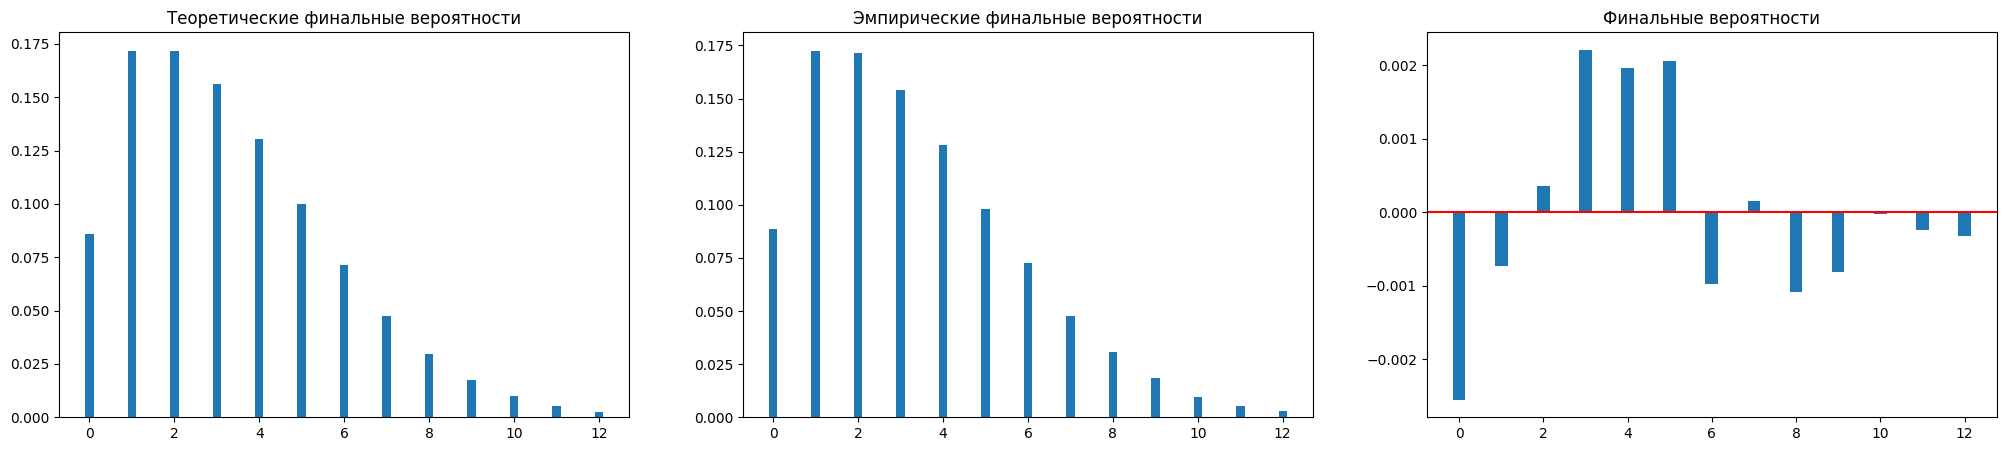

+---------------+---------------------------------+
|  Исследование | Вероятность образования очереди |
+---------------+---------------------------------+
| Теоретическое |           0.7397076216          |
|  Эмпирическое |           0.7360981152          |
+---------------+---------------------------------+
+---------------+--------------------+
|  Исследование | Вероятность отказа |
+---------------+--------------------+
| Теоретическое |    0.0025627807    |
|  Эмпирическое |    0.0028906563    |
+---------------+--------------------+
+---------------+--------------------------------------+
|  Исследование | Относитальная пропускная способность |
+---------------+--------------------------------------+
| Теоретическое |             0.9974372193             |
|  Эмпирическое |             0.9971093437             |
+---------------+--------------------------------------+
+---------------+-----------------------------------+
|  Исследование | Абсолютная пропускная способность |
+---

In [ ]:
print("Тест 1")
test_case(2, 10, 10, 5, 1, 6000, 10)

Тест2
+-------------------------------------+------------------------------------+
| Теоретические финальные вероятности | Эмпирические финальные вероятности |
+-------------------------------------+------------------------------------+
|              1.3578e-06             |             6.6693e-06             |
|              1.3578e-05             |            1.33387e-05             |
|             6.78902e-05             |             7.503e-05              |
|             0.0002263006            |            0.000205082             |
|             0.0005657514            |            0.0005585568            |
|             0.0011315028            |            0.0011171135            |
|             0.0022186329            |            0.0022775777            |
|             0.0042666017            |            0.004193344             |
|             0.0080501919            |            0.0080165399            |
|             0.0149077628            |            0.0145574897       

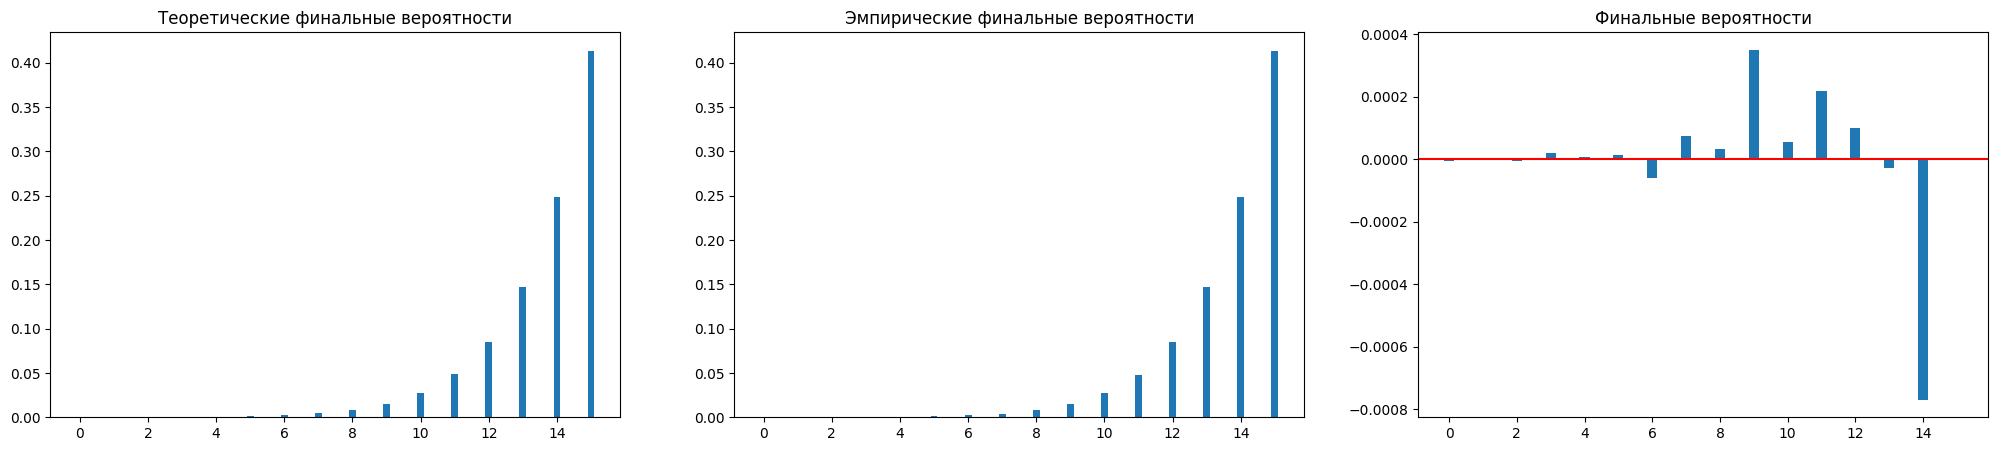

+---------------+---------------------------------+
|  Исследование | Вероятность образования очереди |
+---------------+---------------------------------+
| Теоретическое |           0.5855488204          |
|  Эмпирическое |           0.5855642257          |
+---------------+---------------------------------+
+---------------+--------------------+
|  Исследование | Вероятность отказа |
+---------------+--------------------+
| Теоретическое |    0.4135763016    |
|  Эмпирическое |    0.4135770975    |
+---------------+--------------------+
+---------------+--------------------------------------+
|  Исследование | Относитальная пропускная способность |
+---------------+--------------------------------------+
| Теоретическое |             0.5864236984             |
|  Эмпирическое |             0.5864229025             |
+---------------+--------------------------------------+
+---------------+-----------------------------------+
|  Исследование | Абсолютная пропускная способность |
+---

In [ ]:
print("Тест2")
test_case(5, 10, 100, 10, 1, 6000, 10)

Тест 3
+-------------------------------------+------------------------------------+
| Теоретические финальные вероятности | Эмпирические финальные вероятности |
+-------------------------------------+------------------------------------+
|             0.1466666667            |            0.1473872488            |
|             0.2933333333            |            0.2936210759            |
|             0.2933333333            |            0.2909799071            |
|             0.2666666667            |            0.2680117682            |
+-------------------------------------+------------------------------------+


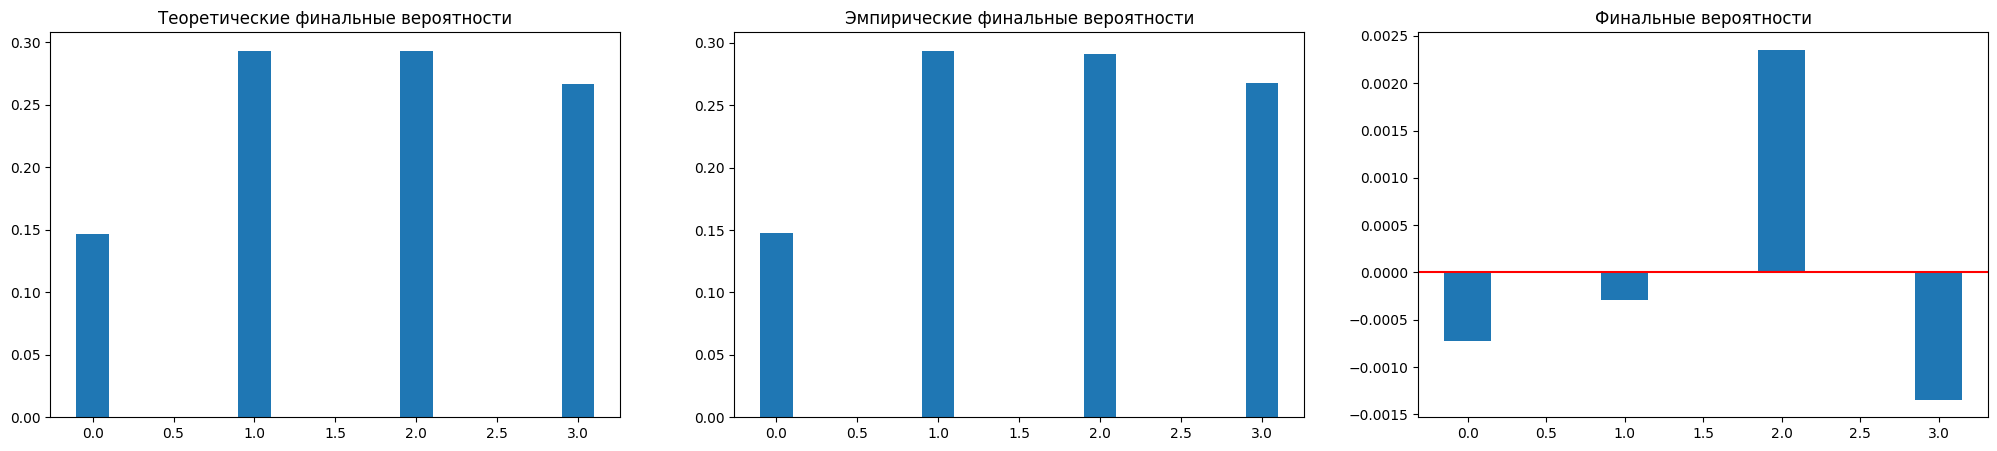

+---------------+---------------------------------+
|  Исследование | Вероятность образования очереди |
+---------------+---------------------------------+
| Теоретическое |           0.2933333333          |
|  Эмпирическое |           0.2909799071          |
+---------------+---------------------------------+
+---------------+--------------------+
|  Исследование | Вероятность отказа |
+---------------+--------------------+
| Теоретическое |    0.2666666667    |
|  Эмпирическое |    0.2680117682    |
+---------------+--------------------+
+---------------+--------------------------------------+
|  Исследование | Относитальная пропускная способность |
+---------------+--------------------------------------+
| Теоретическое |             0.7333333333             |
|  Эмпирическое |             0.7319882318             |
+---------------+--------------------------------------+
+---------------+-----------------------------------+
|  Исследование | Абсолютная пропускная способность |
+---

In [ ]:
print("Тест 3")
test_case(2, 1, 10, 5, 1, 6000, 10)

Тест 4
+-------------------------------------+------------------------------------+
| Теоретические финальные вероятности | Эмпирические финальные вероятности |
+-------------------------------------+------------------------------------+
|             0.818452381             |            0.8254313955            |
|             0.1636904762            |            0.1569777182            |
|             0.0163690476            |            0.0159155637            |
|             0.0014880952            |            0.0016753225            |
+-------------------------------------+------------------------------------+


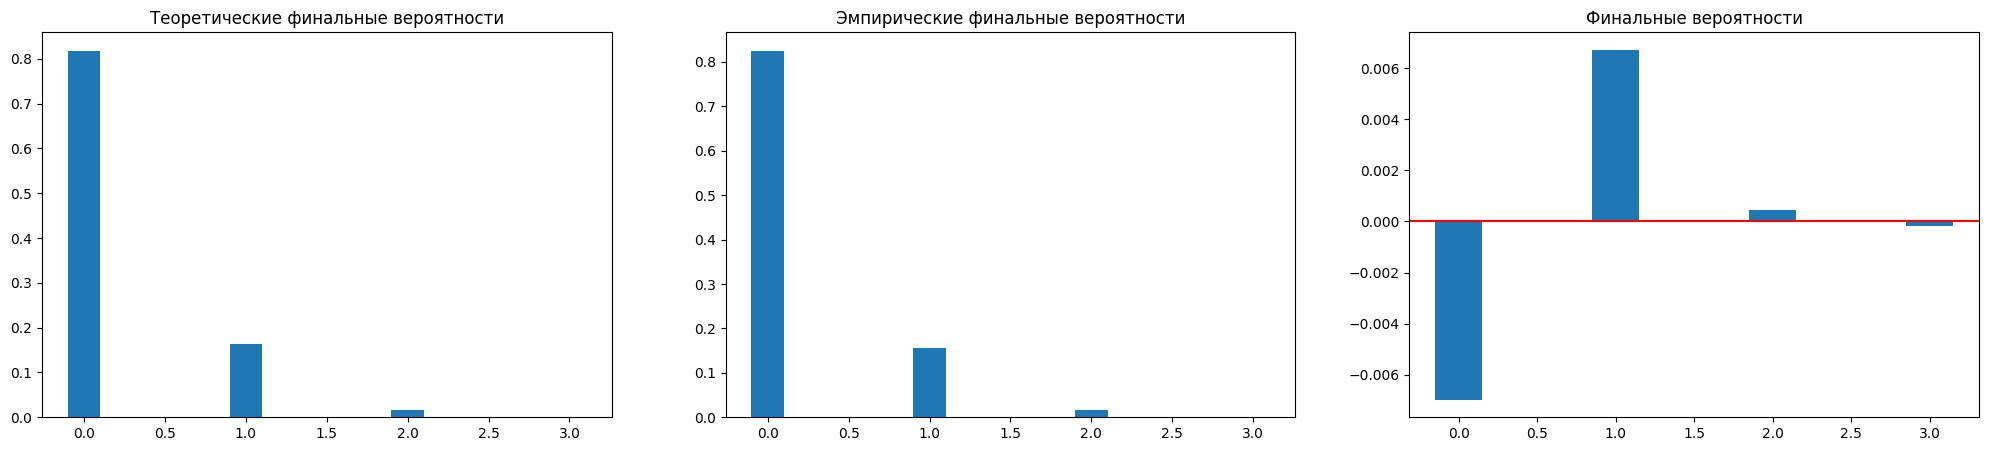

+---------------+---------------------------------+
|  Исследование | Вероятность образования очереди |
+---------------+---------------------------------+
| Теоретическое |           0.0163690476          |
|  Эмпирическое |           0.0159155637          |
+---------------+---------------------------------+
+---------------+--------------------+
|  Исследование | Вероятность отказа |
+---------------+--------------------+
| Теоретическое |    0.0014880952    |
|  Эмпирическое |    0.0016753225    |
+---------------+--------------------+
+---------------+--------------------------------------+
|  Исследование | Относитальная пропускная способность |
+---------------+--------------------------------------+
| Теоретическое |             0.9985119048             |
|  Эмпирическое |             0.9983246775             |
+---------------+--------------------------------------+
+---------------+-----------------------------------+
|  Исследование | Абсолютная пропускная способность |
+---

In [ ]:
print("Тест 4")
test_case(2, 1, 1, 5, 1, 6000, 10)

Тест 5
+-------------------------------------+------------------------------------+
| Теоретические финальные вероятности | Эмпирические финальные вероятности |
+-------------------------------------+------------------------------------+
|             0.0207202763            |            0.0208045123            |
|             0.1036013814            |            0.1046625975            |
|             0.2590034534            |            0.2603614205            |
|             0.616674889             |            0.6141714697            |
+-------------------------------------+------------------------------------+


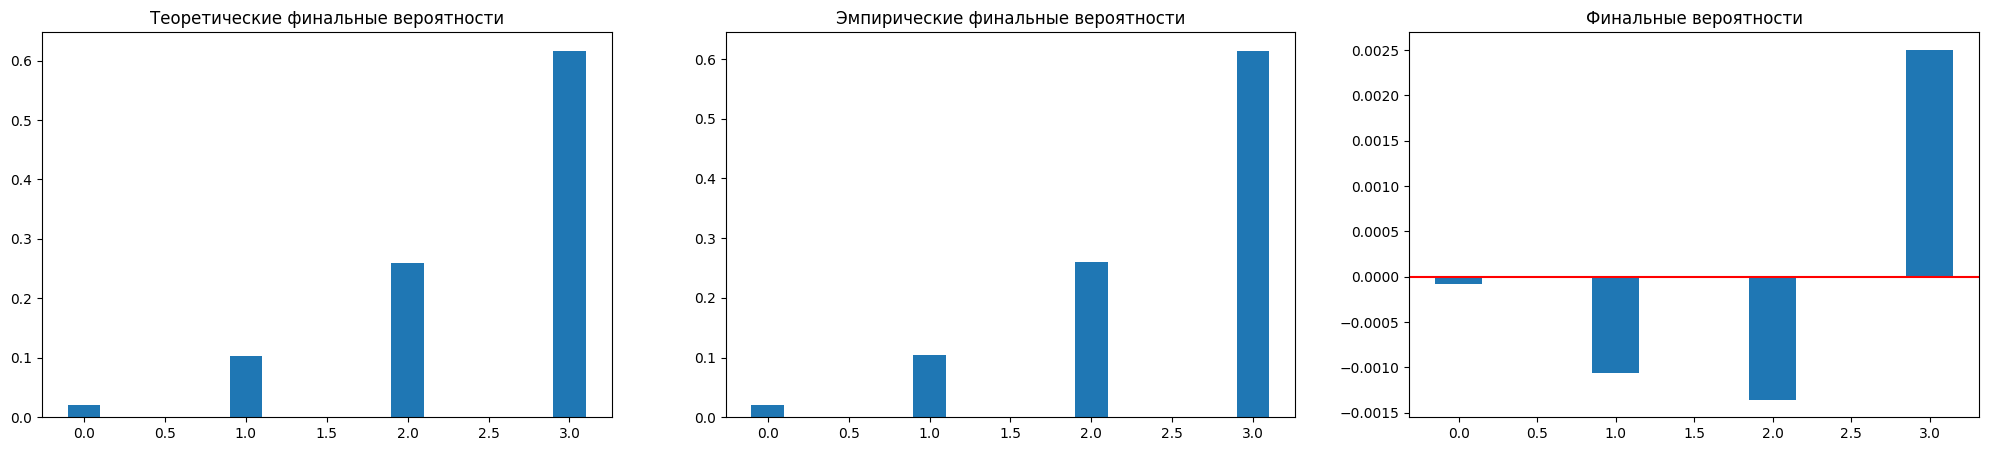

+---------------+---------------------------------+
|  Исследование | Вероятность образования очереди |
+---------------+---------------------------------+
| Теоретическое |           0.2590034534          |
|  Эмпирическое |           0.2603614205          |
+---------------+---------------------------------+
+---------------+--------------------+
|  Исследование | Вероятность отказа |
+---------------+--------------------+
| Теоретическое |    0.616674889     |
|  Эмпирическое |    0.6141714697    |
+---------------+--------------------+
+---------------+--------------------------------------+
|  Исследование | Относитальная пропускная способность |
+---------------+--------------------------------------+
| Теоретическое |             0.383325111              |
|  Эмпирическое |             0.3858285303             |
+---------------+--------------------------------------+
+---------------+-----------------------------------+
|  Исследование | Абсолютная пропускная способность |
+---

In [ ]:
print("Тест 5")
test_case(2, 1, 50, 10, 1, 6000, 10)